# 4章 ニューラルネットワークの学習
## 4.2 損失関数
### 4.2.1 2乗和誤差

教師データ-> 0=fail,1=successで記述することをone-hot表現という

In [ ]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import numpy as np

# 2乗和誤差
def mean_squared_error(y, t):
  return 0.5 * np.sum((y -t) ** 2)

In [ ]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y),np.array(t))

0.09750000000000003

In [ ]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y),np.array(t))

0.5975

### 4.2.2 交差エントロピー誤差

In [ ]:
# 交差エントロピー誤差
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta))

In [ ]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [ ]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### 4.2.3 ミニバッチ学習
無作為抽出した単位で学習する手法

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DeepLearningFromScratch')
import numpy as np
from official.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [ ]:
print(x_train.shape)

(60000, 784)


In [ ]:
print(t_train.shape)

(60000, 10)


In [ ]:
# 10枚だけランダム抽出
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
np.random.choice(60000, 10)

array([ 9963,  1208, 59668, 13860, 58561, 20575, 22936, 53859, 53874,
       24111])

### 4.2.4 [バッチ対応版]交差エントロピー誤差の実装

In [ ]:
# バッチ対応, one-hot表現, 交差エントロピー誤差
def cross_entropy_error_for_batch_one_hot(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  batch_size = y.shape[0]
  return -np.sum(t * np.log(y)) / batch_size

In [ ]:
# バッチ対応, ラベル, 交差エントロピー誤差
def cross_entropy_error_for_batch_label(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  batch_size = y.shape[0]
  return -np.sum(t * np.log(y[np.arange(batch_size), t])) / batch_size

### 4.2.5 なぜ損失関数を実装するのか？

* 損失関数に対して特定の重みパラメータに関する(偏)微分結果から重みパラメータを変更していく
* 精度を使うことにするとほとんどの領域で微分結果=0となり学習が進まない
  * 精度とは「テスト数に対する正解数の割合」でしかなのでテストが大量にないと分解能が低すぎる
    * 数億のパラメータの1つを少量変えただけで結果が反映される程度でないといけない
  * 活性化関数をsigmoidにする理由も同じで微分可能性がありかつ全領域で微分=0にならない関数を採用する必要がある



## 4.3 数値積分
### 4.3.1 微分
というか数値微分。解析微分(=数式でやる計算)ではない

In [ ]:
# 数値微分
def numerical_diff(f, x):
  h = 1e-4
  return (f(x + h) - f(x - h)) / (2 * h)

### 4.3.2 数値微分の例

In [ ]:
def function_1(x):
  return 0.01 * x ** 2 + 0.1 * x

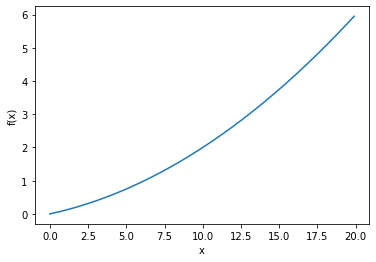

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [ ]:
numerical_diff(function_1, 5)

0.1999999999990898

In [ ]:
numerical_diff(function_1, 10)

0.2999999999986347

### 4.3.3 偏微分

In [ ]:
def function_2(x):
  return x[0] **2 + x[1] **2

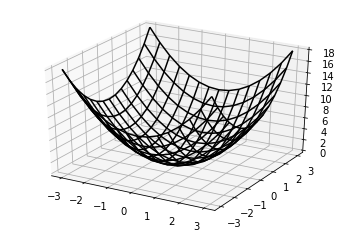

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

x0 = np.linspace(-3, 3, 15)
x1 = np.linspace(-3, 3, 15)
X0, X1 = np.meshgrid(x0, x1)
Y = function_2([X0, X1])
ax.plot_wireframe(X0, X1, Y, color='black')

## 4.4 勾配

In [ ]:
# 勾配
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)
  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = tmp_val + h
    fxh1 = f(x)
    x[idx] = tmp_val - h
    fxh2 = f(x)
    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp_val
  return grad

In [ ]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [ ]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [ ]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

### 4.4.1 勾配法
勾配降下法の偏微分項の係数を学習率という

In [ ]:
# 勾配降下法
def gradient_descent(f, init_x, learning_rate=0.01, step_num=100):
  x = init_x
  for i in range(step_num):
    grad = numerical_gradient(f, x)
    x -= learning_rate * grad
  return x

(-3.0, 4.0)からfunction_2の最小値を探す

In [ ]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, learning_rate=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

学習率過大、あちこちに移動しすぎる

In [ ]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, learning_rate=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

学習率過小、動きが小さすぎる

In [ ]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, learning_rate=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

### 4.4.2 ニューラルネットワークに対する勾配
評価関数に対するネットワークの重みパラメータごとの偏微分をまとめて求める

In [ ]:
# テスト用のネットワーク
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DeepLearningFromScratch')
import numpy as np
from functions import softmax, cross_entropy_error
## Colab上ではなぜか自前のコードが通らない、ローカルだと通る。代わりにofficialのコードを使う
#from functions import numerical_gradient
from official.common.gradient import numerical_gradient

class SimpleNet:
  def __init__(self):
    self.W = np.random.randn(2, 3)

  def predict(self, x):
    return np.dot(x, self.W)

  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y, t)
    return loss

In [ ]:
net = SimpleNet()
print(net.W)

[[ 1.04972515  2.2142032  -0.25209092]
 [-0.71110516 -0.12432839 -0.18324504]]


In [ ]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.01015955  1.21662637 -0.31617509]


In [ ]:
np.argmax(p)

1

In [ ]:
t = np.array([0, 0, 1])
net.loss(x, t)

1.9443562475491898

In [ ]:
def f(W):
  return net.loss(x, t)

In [ ]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.11658114  0.39757098 -0.51415212]
 [ 0.17487172  0.59635646 -0.77122818]]


In [201]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

## 4.5 学習アルゴリズムの実装
SGD: 確率的勾配降下法
### 4.5.1 2層ニューラルネットワークのクラス

In [243]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DeepLearningFromScratch')
from functions import *
#from functions import numerical_gradient
from official.common.gradient import numerical_gradient

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 重み初期化
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    # 出力計算
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)
    return y

  def loss(self, x, t):
    # 損失関数
    y = self.predict(x)
    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    # 精度
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    # 勾配
    loss_W = lambda W: self.loss(x, t)
    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

In [244]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [245]:
net.params['b1'].shape

(100,)

In [246]:
net.params['W2'].shape

(100, 10)

In [247]:
net.params['b2'].shape

(10,)

In [248]:
x = np.random.rand(100, 784)
y = net.predict(x)

適当にデータ捏造して勾配を計算してみる(時間がかかる)

In [249]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)
grads = net.numerical_gradient(x, t)

In [250]:
grads['W1'].shape

(784, 100)

In [251]:
grads['b1'].shape

(100,)

In [252]:
grads['W2'].shape

(100, 10)

In [253]:
grads['b2'].shape

(10,)

### 4.5.2 ミニバッチ学習の実装

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DeepLearningFromScratch')
import numpy as np
from official.dataset.mnist import load_mnist
#from twolayernet import TwoLayerNet

(x_training, t_training), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
training_loss_list = []

# hyper parameters
iters_num = 10000
training_size = x_training.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  # ミニバッチの取得
  batch_mask = np.random.choice(training_size, batch_size)
  x_batch = x_training[batch_mask]
  t_batch = t_training[batch_mask]
  # 勾配計算
  grad = network.numerical_gradient(x_batch, t_batch)
  # update
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]
  # record
  loss = network.loss(x_batch, t_batch)
  training_loss_list.append(loss)


### 4.5.3 テストデータで評価
ものすごく時間がかかるのでここでは省略  
途中経過を監視する仕組みがないとダメだと思う。

# 4章終わり